In [1]:
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt

def handled_input(output:str, isInt = False):
    s = input(output)
    while True:
        try:
            if isInt:
                s = int(s)
            else:
                s = float(s)
            if s < 0:
                s = input(output)
                continue
            break
        except ValueError:
            s = input('Wring input.' + output)
    return s

In [2]:
# Input

S0 = handled_input('Current stock price:')
sigma = handled_input('Volatility:')
forward_rate = handled_input('Forward_rate (%):')/100
length = handled_input('Maturing time (in year):', isInt = True)
timestep = handled_input('Maturing period left:', isInt = True)
X = handled_input('Strike Price:')
r =  handled_input('Riskless Rate of return (%):')/100
num_paths = handled_input('# of Monte Carlo sample:', isInt = True)
a = handled_input("'a' value for Hull White Model:")

np.random.seed(1204)
dt = length / timestep
day_count = ql.Thirty360()
todays_date = ql.Date(12, 5, 2020)

Current stock price: 100
Volatility: 0.1
Forward_rate (%): 5
Maturing time (in year): 1
Maturing period left: 360
Strike Price: 105
Riskless Rate of return (%): 3
# of Monte Carlo sample: 100
'a' value for Hull White Model: 0.1


In [3]:
ql.Settings.instance().evaluationDate = todays_date

spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)

In [4]:
def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

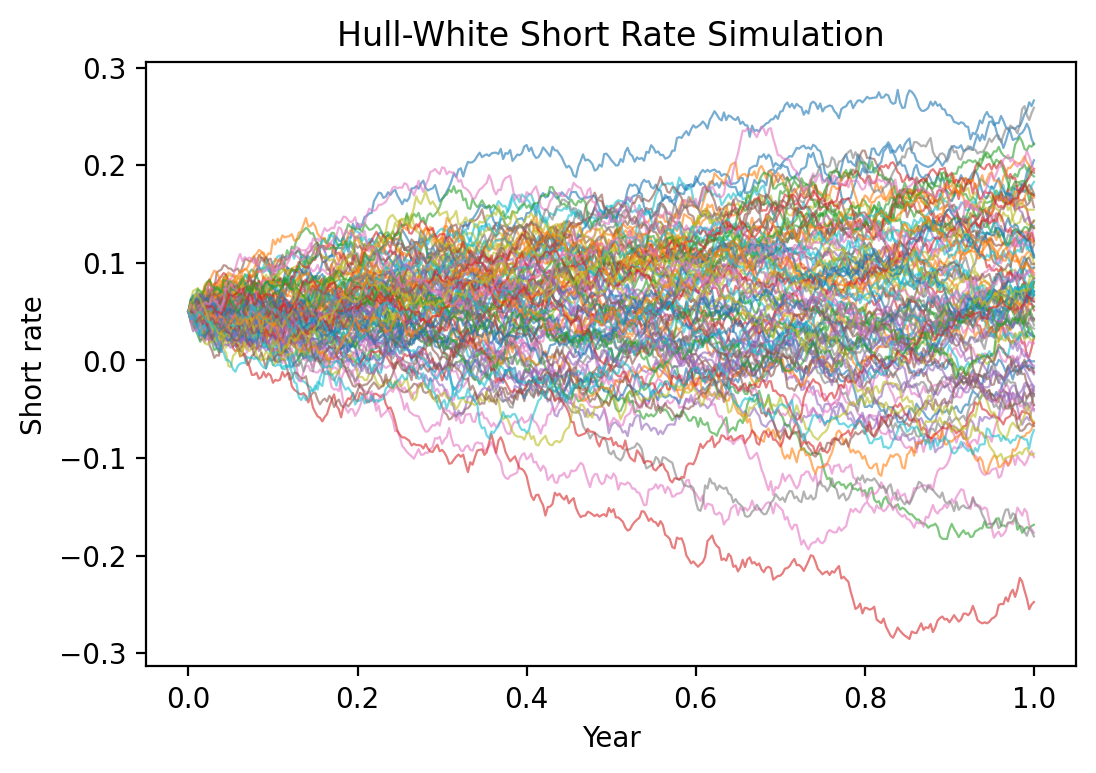

In [5]:
time, sr_paths = generate_paths(num_paths, timestep)
plt.figure(figsize = (6, 4), dpi = 200)
for i in range(num_paths):
    plt.plot(time, sr_paths[i, :], lw=0.8, alpha=0.6)
plt.title("Hull-White Short Rate Simulation")
plt.xlabel('Year')
plt.ylabel('Short rate')
plt.show()

In [6]:
def genBrownPath (T, mu, sigma, S0, dt):
    S = []
    W = [0] + np.random.standard_normal(size = 1) 
    W = (W + np.random.standard_normal(size = 1))*np.sqrt(dt)
    for i in range(len(time)):
        X_ = float(mu[i] - 0.5 * sigma**2) * float(time[i]) + sigma * W 
        S.append(S0 * np.exp(X_)) # == geometric brownian motion
    plt.plot(time, S)
    return S

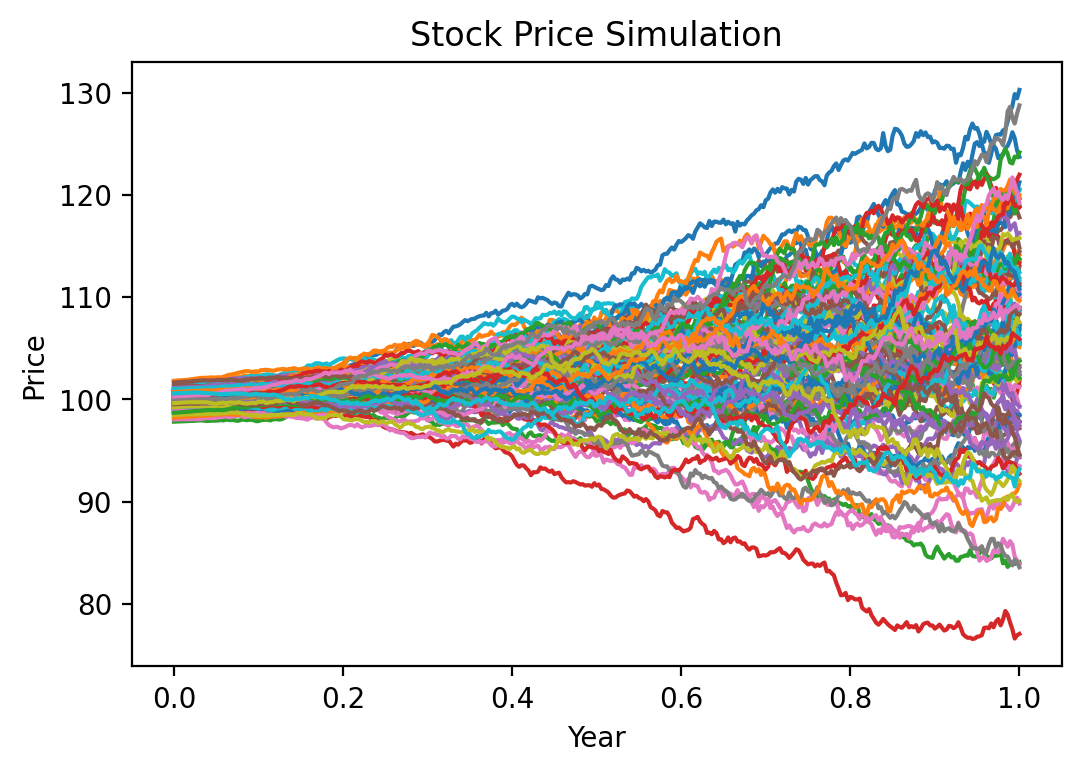

In [7]:
p_paths = []
plt.figure(figsize = (6, 4), dpi = 200)
for i in range(num_paths):
    p_paths.append(genBrownPath(timestep, sr_paths[i, :], sigma, S0, dt))
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Stock Price Simulation')
plt.show()

In [8]:
# Output
call, put = [], []
for i in range(num_paths - 1):
    price = p_paths[i][timestep]
    if price - X > 0:
        payoff = price - X
        call.append(payoff + np.exp(-1.0*r*i)*payoff)
    if X - price > 0:
        payoff = X - price
        put.append(payoff + np.exp(-1.0*r*i)*payoff)

print('Put value is ' + str(round(np.mean(put), 3)) + '.')
print('Call value is ' + str(round(np.mean(call), 3)) + '.')


Put value is 10.767.
Call value is 10.342.
